Let's make a skincancer classifier!!

You can see the dataset [**here**](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000), this notebook is final assignment of [**Belajar Pengembangan Machine Learning**](https://www.dicoding.com/academies/185) Course on Dicoding, created by [**Satria Kemal**](https://www.dicoding.com/users/codesigma)

# Data Preparation

Importing libraries

In [34]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

import os

Load dataset

In [35]:
FilePath = "../input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
df = pd.read_csv(FilePath)

let's look at the dataframe, each column represents a pixel value, we have to convert them into 28x28x3 before throw them into models

In [36]:
df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [37]:
label = df["label"]
df = df.drop(columns=["label"]) 

Plot label distribution

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

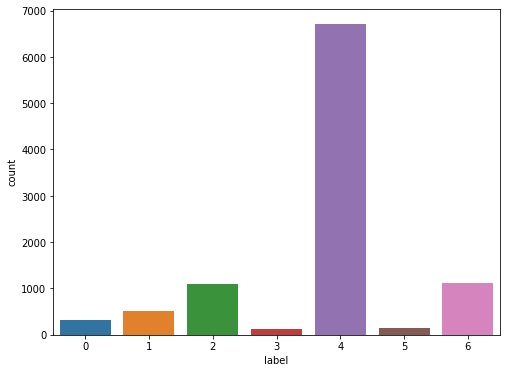

In [38]:
plt.figure(figsize = (8,6))
sns.countplot(label)

Splitting dataset into train and test set

In [39]:
X_train , X_test , y_train , y_test = train_test_split(df , label , test_size = 0.2)

Imbalanced dataset might hurt the performance of our models, so we have to make them balanced. 

One of the methods can we use is oversamping.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

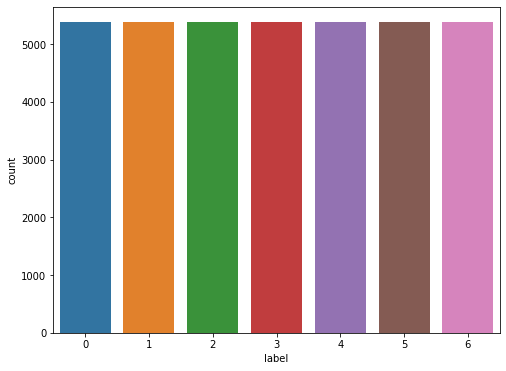

In [40]:
sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)

plt.figure(figsize = (8,6))
sns.countplot(y_train)

 Reshape the data so it can be thrown into the model

In [41]:

X_train = np.array(X_train).reshape(-1,28,28,3)
X_test = np.array(X_test).reshape(-1,28,28,3)

Image examples after we converted the dataframe into 28x28x3 matrices

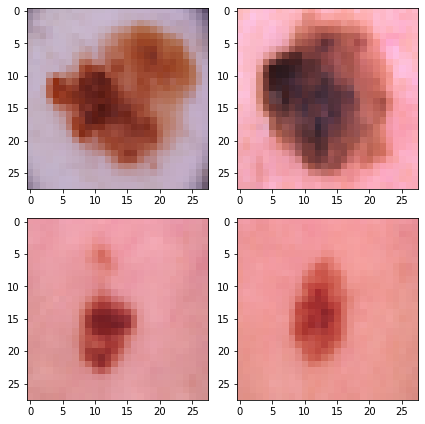

In [42]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
k = 0 
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(X_train[k])
        k += 1
plt.tight_layout()

Encode the labels, so we can use them for training

They will look like this: [0, 1, 0, 0, 0, 0, 0] to represent label 1 (0-based indexing)

In [43]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Modelling

Custom metrics, F1-Score

In [44]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


For this problem, this architecture works best so far

In [45]:
model = Sequential([
            Input(shape = [28,28,3]),
            Conv2D(64 , (3,3) , activation='relu',padding='same'),
            MaxPooling2D(),
            BatchNormalization(),
            Conv2D(128 , (3,3) , activation='relu',padding='same'),
            Conv2D(128 , (3,3) , activation='relu',padding='same'),
            MaxPooling2D(),
            BatchNormalization(), 
            Conv2D(256 , (3,3) , activation='relu',padding='same'),
            Conv2D(256 , (3,3) , activation='relu',padding='same'),
            MaxPooling2D(),
            BatchNormalization(),
            Conv2D(512 , (3,3) , activation='relu',padding='same'),
            Conv2D(512 , (3,3) , activation='relu',padding='same'),
            MaxPooling2D(),
#             BatchNormalization(),
#             Conv2D(512 , (3,3) , activation='relu',padding='same'),
#             Conv2D(512 , (3,3) , activation='relu',padding='same'),
#             MaxPooling2D(),
            Flatten(),
            Dropout(.5),
            Dense(256, activation = 'relu'),
            BatchNormalization(),
            Dropout(.5),
            Dense(128, activation = 'relu'),
            BatchNormalization(),
            Dropout(.5),
            Dense(64, activation = 'relu'),
            BatchNormalization(),
            Dense(32, activation = 'relu'),
            BatchNormalization(),
            Dense(7, activation = 'softmax'),
])

model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=[f1_m, 'accuracy'])

Create model save path for checkpoint callback and saving models

In [46]:
#make model folder model
model._name = 'skincancer_CNN'
model_save_path = "."
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

Callbacks

In [47]:
early_stop = EarlyStopping(patience=10, verbose=1, monitor='val_f1_m', mode='max')
reduce_lr =  ReduceLROnPlateau(monitor='val_f1_m', factor=0.1, patience=7, min_delta=1e-4, mode='max')
checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_f1_m', mode='max')

In [48]:
model.summary()

Model: "skincancer_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 7, 7, 128)      

# Training

In [49]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    steps_per_epoch=len(X_train)//128,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/50
294/294 [==============================] - 8s 19ms/step - loss: 1.8569 - f1_m: 0.1212 - accuracy: 0.2631 - val_loss: 1.3705 - val_f1_m: 0.5140 - val_accuracy: 0.5202

Epoch 00001: val_f1_m improved from -inf to 0.51400, saving model to ./skincancer_CNN.h5
Epoch 2/50
294/294 [==============================] - 6s 18ms/step - loss: 1.0187 - f1_m: 0.4889 - accuracy: 0.5937 - val_loss: 1.5099 - val_f1_m: 0.3240 - val_accuracy: 0.3575

Epoch 00002: val_f1_m did not improve from 0.51400
Epoch 3/50
294/294 [==============================] - 5s 18ms/step - loss: 0.5513 - f1_m: 0.7993 - accuracy: 0.8072 - val_loss: 1.3166 - val_f1_m: 0.5420 - val_accuracy: 0.5472

Epoch 00003: val_f1_m improved from 0.51400 to 0.54197, saving model to ./skincancer_CNN.h5
Epoch 4/50
294/294 [==============================] - 5s 18ms/step - loss: 0.3870 - f1_m: 0.8647 - accuracy: 0.8654 - val_loss: 1.1760 - val_f1_m: 0.6435 - val_accuracy: 0.6490

Epoch 00004: val_f1_m improved from 0.54197 to 0.64350, 

# Plot Training

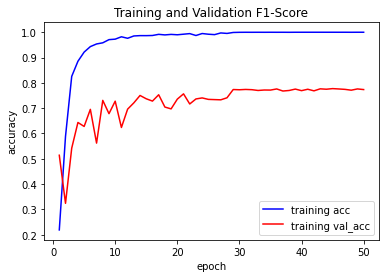

In [52]:
f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
epochs = range(1, len(val_f1) + 1)

plt.plot(epochs, f1, color="blue", label="training acc")
plt.plot(epochs, val_f1, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation F1-Score")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

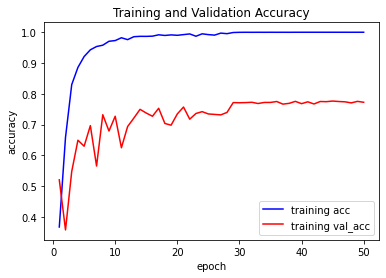

In [53]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="training acc")
plt.plot(epochs, val_acc, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

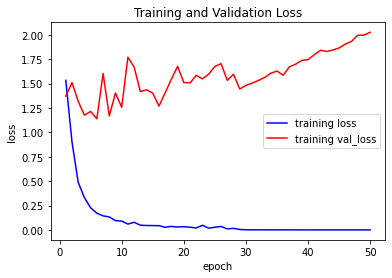

In [54]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, loss, color="blue", label="training loss")
plt.plot(epochs, val_loss, color="red", label="training val_loss")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()

# Convert to TFLite

In [55]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [56]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

**THAT'S IT!!**, Please give me some suggestions or tips to improve this models, thanks :)